In [32]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


In [2]:
df=pd.read_csv('lcar.csv')
df.head()

,Unnamed: 0,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,brand,model
0,0,1003000,86226,Diesel,Man,1,2017,1956,5,Jeep,Compass 2.0
1,1,1283000,13248,Petrol,Auto,1,2021,1330,5,Renault,Duster RXZ
2,2,1640000,60343,Petrol,Auto,1,2016,2494,5,Toyota,Camry 2.5
3,3,777000,26696,Petrol,Auto,1,2018,1199,5,Honda,Jazz VX
4,4,515000,69414,Petrol,Man,1,2016,1199,5,Volkswagen,Polo 1.2


In [3]:
df.isnull().sum()

Unnamed: 0             0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
brand                  0
model                  0
dtype: int64

In [4]:
df = df.drop(df.columns[0], axis=1)

In [5]:
df = df.dropna()

In [6]:
# Hypothesis Testing
# Numerical: kms_driven vs. price
spearman_corr, spearman_p = stats.spearmanr(df['kms_driven'], df['car_prices_in_rupee'])
print(f"Spearman Correlation (kms_driven vs. price): {spearman_corr:.3f}, p-value: {spearman_p:.3f}")

Spearman Correlation (kms_driven vs. price): -0.342, p-value: 0.000


In [7]:
#Categorical: brand vs. price
brand_groups = [group['car_prices_in_rupee'].values for name, group in df.groupby('brand')]
anova_f, anova_p = stats.f_oneway(*brand_groups)
print(f"ANOVA (brand vs. price): F-statistic: {anova_f:.3f}, p-value: {anova_p:.3f}")

ANOVA (brand vs. price): F-statistic: 251.064, p-value: 0.000


In [8]:
# Preprocessing
df_encoded = df.copy()


In [9]:
le_brand = LabelEncoder()
le_model = LabelEncoder()

In [10]:
df_encoded['brand'] = le_brand.fit_transform(df['brand'])
df_encoded['model'] = le_model.fit_transform(df['model'])
df_encoded = pd.get_dummies(df_encoded, columns=['fuel_type', 'transmission'], drop_first=True, dtype=int)
df_encoded['car_age'] = 2025 - df_encoded['manufacture']
df_encoded = df_encoded.drop('manufacture', axis=1)

In [11]:
scaler = StandardScaler()
numerical_cols = ['kms_driven', 'engine', 'Seats', 'car_age']
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

In [13]:
# split data
X=df_encoded.drop(columns='car_prices_in_rupee')
y=df_encoded['car_prices_in_rupee']

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
#model tuning
param_grid={
    'n_estimators':[100,200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [17]:
rf = RandomForestRegressor(random_state=42)

In [18]:
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [ ]:
#NOT FOR GENERAL USE
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# best_model = grid_search.best_estimator_
# results = grid_search.cv_results_
# print(results)


{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [23]:
# Evaluate tuned model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

In [24]:

y_pred = best_rf.predict(X_test)


In [25]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [26]:
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Tuned Random Forest - MAE: {mae:.2f}")
print(f"Tuned Random Forest - R²: {r2:.2f}")


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest - MAE: 217937.45
Tuned Random Forest - R²: 0.82


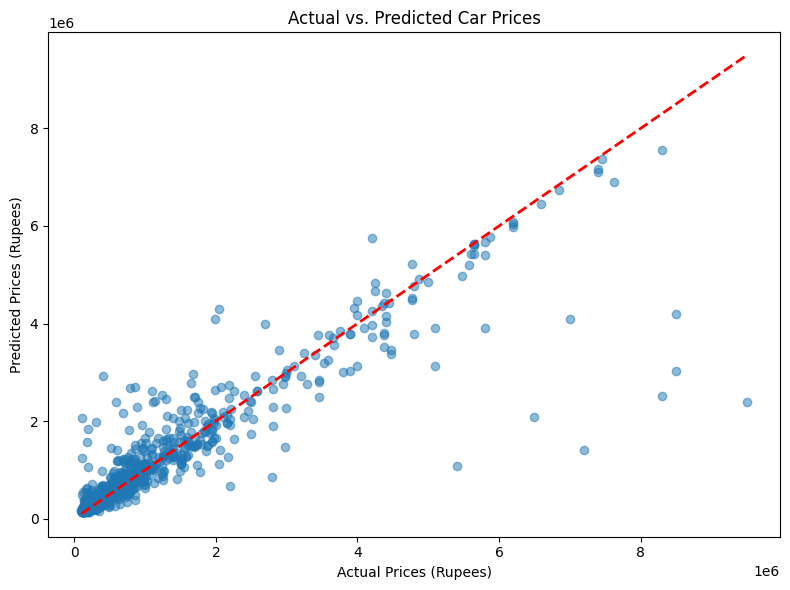

In [29]:
# Step 7: Visualize Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices (Rupees)')
plt.ylabel('Predicted Prices (Rupees)')
plt.title('Actual vs. Predicted Car Prices')
plt.tight_layout()
plt.show()

In [30]:
# Step 8: Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\n--- Feature Importance ---")
print(feature_importance)


--- Feature Importance ---
               Feature  Importance
10    transmission_Man    0.355018
5                model    0.186624
4                brand    0.139927
11             car_age    0.129067
0           kms_driven    0.093511
6     fuel_type_Diesel    0.043948
2               engine    0.030301
1            ownership    0.007743
9     fuel_type_Petrol    0.007613
3                Seats    0.006067
7   fuel_type_Electric    0.000180
8        fuel_type_Lpg    0.000001


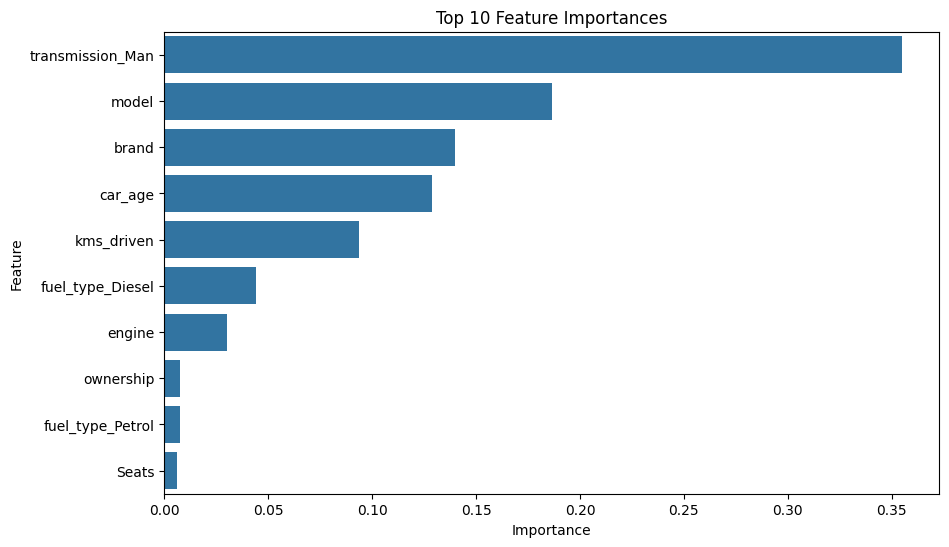

In [33]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [34]:
import joblib
joblib.dump(best_rf, 'best_car_price_model.pkl')

['best_car_price_model.pkl']

In [35]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_brand, 'le_brand.pkl')
joblib.dump(le_model, 'le_model.pkl')
print("\nModel and preprocessors saved.")


Model and preprocessors saved.


In [22]:

import numpy as np
import joblib

# Load saved models
best_model = joblib.load("best_car_price_model.pkl")
le_brand = joblib.load("le_brand.pkl")
le_model = joblib.load("le_model.pkl")

# Sample car data (change values to test different cars)
sample_car = {
    "brand": "Maruti Suzuki",
    "model": "Alto",
    "kms_driven": 30000,
    "engine": 796,
    "seats": 5,
    "car_age": 5,
    "fuel_type": "Petrol",  # Change if different
    "transmission": "Manual"  # Change if different
}

# Handle unknown brands & models
try:
    brand_encoded = le_brand.transform([sample_car["brand"]])[0]
except:
    brand_encoded = 0  # Default value if unknown

try:
    model_encoded = le_model.transform([sample_car["model"]])[0]
except:
    model_encoded = 0  # Default value if unknown

# Handle missing numerical values
kms_driven = sample_car.get("kms_driven", 0)  # Default: 0
engine = sample_car.get("engine", 1000)  # Default: 1000cc
seats = sample_car.get("seats", 5)  # Default: 5 seats
car_age = sample_car.get("car_age", 5)  # Default: 5 years

# One-hot encode fuel type (default: Petrol)
fuel_types = ["Diesel", "Electric", "Lpg", "Petrol"]
fuel_encoding = [1 if sample_car.get("fuel_type", "Petrol") == f else 0 for f in fuel_types]

# One-hot encode transmission (default: Manual)
transmission_encoding = [1] if sample_car.get("transmission", "Manual") == "Manual" else [0]

# Create the final input array
test_features = np.array([
    kms_driven, 1, engine, seats, brand_encoded, model_encoded, 
    *fuel_encoding, *transmission_encoding, car_age
]).reshape(1, -1)

# Predict car price
predicted_price = best_model.predict(test_features)[0]
print(f"Predicted Car Price: {predicted_price}")


Predicted Car Price: 219790.0


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
